In [2]:
# testing filtering
#imports
import spatialdata
import dask_image.imread
import dask.array as da
import geopandas as gpd
import anndata as ad
import napari_spatialdata
import time

import sys, os
sys.path.append(os.path.abspath("../functions/"))
import filtering
import anndata_utils

from loguru import logger
import shapely
import ast

for package in [spatialdata, gpd, ad, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/default/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


spatialdata: 0.2.3
geopandas: 1.0.1
anndata: 0.11.3
napari_spatialdata: 0.5.3


In [3]:
sdata = spatialdata.read_zarr("../data/exemplar001/exemplar001.zarr")

In [4]:
path_to_geojson = "../data/geojsons/exemplar001/exemplar001_artefacts_wclasses.geojson"

gdf = gpd.read_file(path_to_geojson)
assert gdf.geometry is not None, "No geometry found in the geojson file"
assert gdf.geometry.type.unique()[0] == 'Polygon', "Only polygon geometries are supported"
logger.info(f"GeoJson loaded, detected: {len(gdf)} annotations")

2025-01-15 12:08:55.557 | INFO     | __main__:<module>:6 - GeoJson loaded, detected: 17 annotations


In [5]:
# process the geojson
gdf['class_name'] = gdf['classification'].apply(lambda x: ast.literal_eval(x).get('name') if isinstance(x, str) else x.get('name'))

In [6]:
adata = sdata['imaging'].copy()

#process adata
adata.obs['point_geometry'] = adata.obs.apply(lambda cell: shapely.geometry.Point( cell['X_centroid'], cell['Y_centroid']), axis=1)

In [7]:
#label based on polygon index
def label_point_if_inside_polygon(point, polygons):
    for i, polygon in enumerate(polygons):
        if polygon.contains(point):
            return True
    return False

# label based on polygon class_name
def label_cells_with_annotation_class(adata, geodataframe):
    for index, row in geodataframe.iterrows():
        adata.obs[row['class_name']] = adata.obs['point_geometry'].apply(lambda x: label_point_if_inside_polygon(x, [row['geometry']]))


def label_point_if_inside_polygon_wclassname(point, geodataframe):
    for index, row in geodataframe.iterrows():
        if row['geometry'].contains(point):
            return row['class_name']
    return None

#single column with all classes
def label_cells_with_annotation_class_single_column(adata, geodataframe):
    adata.obs['annotation'] = adata.obs['point_geometry'].apply(lambda x: label_point_if_inside_polygon_wclassname(x, geodataframe))

In [8]:
label_cells_with_annotation_class(adata, gdf)
label_cells_with_annotation_class_single_column(adata, gdf)

In [9]:
labels_to_plot = list(gdf.class_name.unique())
max_x, max_y = adata.obs[['X_centroid', 'Y_centroid']].max()

In [10]:
adata.obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,DNA_6_above_5000,DNA_6_below_25000,DNA_6_filter,shapes,point_geometry,Autofluorescence,CD16_cells,annotation
0,1,258.003817,1768.854962,262,18.967496,17.676168,0.362667,0.102867,0.811146,0.949275,True,True,True,mask_polygons,POINT (1768.854961832061 258.0038167938931),False,False,None
1,2,662.910714,1071.553571,112,13.456567,10.658541,0.610430,-0.149277,0.783217,0.949153,True,True,True,mask_polygons,POINT (1071.553571428571 662.9107142857143),False,False,None
2,3,667.654867,1109.185841,226,19.693311,15.227421,0.634128,1.009633,0.699690,0.900398,True,True,True,mask_polygons,POINT (1109.1858407079646 667.6548672566372),False,False,None
3,4,674.850220,1326.766520,227,17.455343,16.809391,0.269523,1.005338,0.700617,0.926531,True,True,True,mask_polygons,POINT (1326.7665198237885 674.8502202643172),False,False,None
4,5,676.988571,907.400000,175,16.430375,13.860761,0.536963,1.339714,0.729167,0.906736,False,True,False,mask_polygons,POINT (907.4 676.9885714285714),False,False,None


In [15]:
tmp_df_ann = adata.obs[adata.obs['annotation'].isin(labels_to_plot)]
tmp_df_notann = adata.obs[~adata.obs['annotation'].isin(labels_to_plot)].sample(frac=0.2, random_state=0).reset_index(drop=True)

In [23]:
min_x, min_y = adata.obs[['X_centroid', 'Y_centroid']].min()

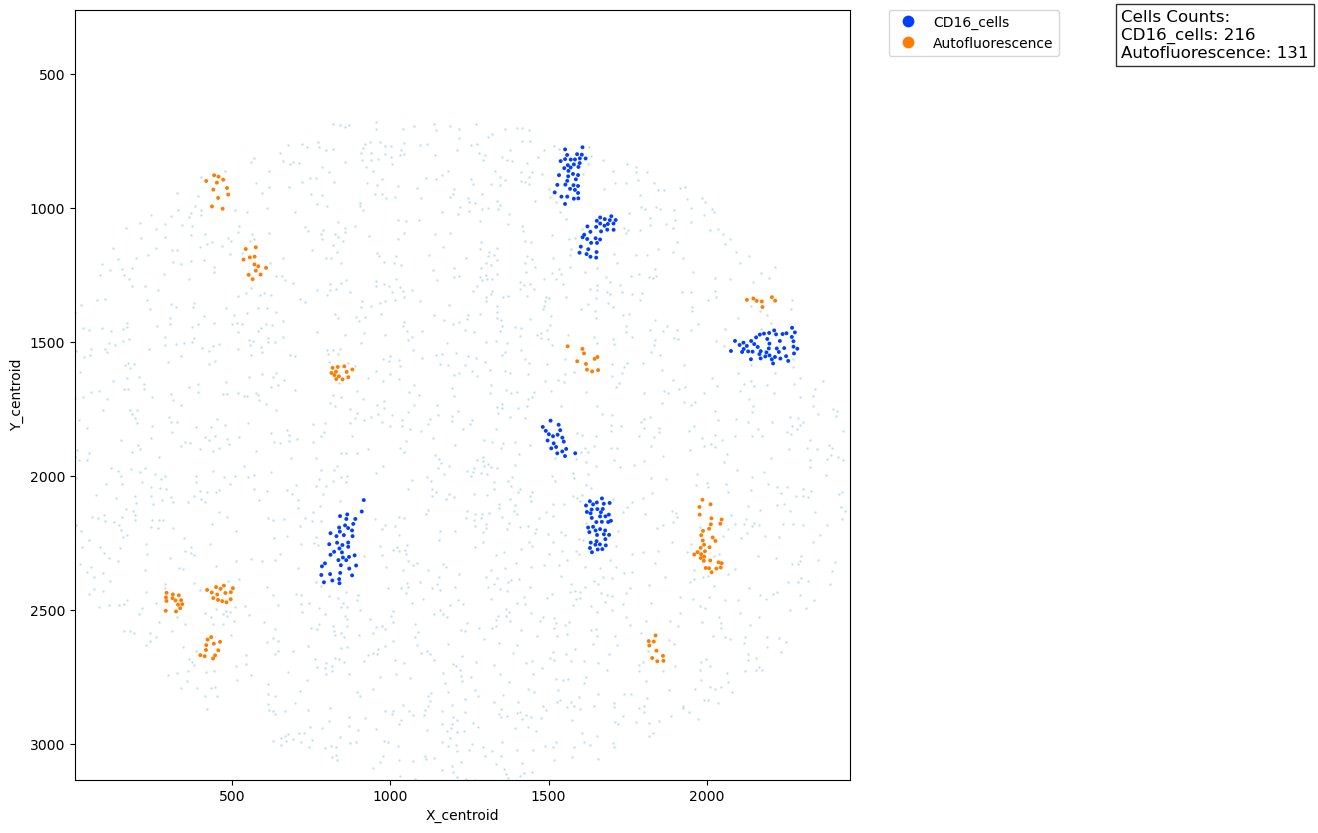

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=tmp_df_notann, x='X_centroid', y='Y_centroid', linewidth=0, s=3, alpha=0.25)
sns.scatterplot(data=tmp_df_ann, x='X_centroid', y='Y_centroid', hue='annotation', palette='bright', linewidth=0, s=8)

plt.xlim(min_x, max_x)
plt.ylim(max_y, min_y)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=3)

# Show value counts
value_counts = tmp_df_ann['annotation'].value_counts()
value_counts_str = "\n".join([f"{cat}: {count}" for cat, count in value_counts.items()])

plt.gca().text(1.35, 1, f"Cells Counts:\n{value_counts_str}",
            transform=plt.gca().transAxes, 
            fontsize=12, 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()

In [38]:
adata.obs.head()

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,DNA_6_above_5000,DNA_6_below_25000,DNA_6_filter,shapes,point_geometry,Autofluorescence,CD16_cells,annotation
0,1,258.003817,1768.854962,262,18.967496,17.676168,0.362667,0.102867,0.811146,0.949275,True,True,True,mask_polygons,POINT (1768.854961832061 258.0038167938931),False,False,None
1,2,662.910714,1071.553571,112,13.456567,10.658541,0.610430,-0.149277,0.783217,0.949153,True,True,True,mask_polygons,POINT (1071.553571428571 662.9107142857143),False,False,None
2,3,667.654867,1109.185841,226,19.693311,15.227421,0.634128,1.009633,0.699690,0.900398,True,True,True,mask_polygons,POINT (1109.1858407079646 667.6548672566372),False,False,None
3,4,674.850220,1326.766520,227,17.455343,16.809391,0.269523,1.005338,0.700617,0.926531,True,True,True,mask_polygons,POINT (1326.7665198237885 674.8502202643172),False,False,None
4,5,676.988571,907.400000,175,16.430375,13.860761,0.536963,1.339714,0.729167,0.906736,False,True,False,mask_polygons,POINT (907.4 676.9885714285714),False,False,None
